# 02. Whole Spine Detection

This tutorial shows an example of using SpineNet to detect vertebral bodies in a STIR whole spine sagittal scan. Note that the provided IVD grading model will not work for this example as it is trained on T2 lumbar IVDs, however these detections and the existing code could be used to train a new model for such examples, provided one has a suitable training dataset. We aim to release a tutorial demonstrating how to finetune/retrain the grading model soon. 

### Load in SpineNet 

Note that if you have not already downloaded SpineNet's weights from tutorial `01-quickstart.ipynb`, you will need to do this before running this notebook via `spinenet.download_weights(verbose=True, force=False)`.


In [2]:
import sys
import os
from pathlib import Path
sys.path.insert(0, str(Path(os.getcwd()).parent)) # Add parent directory to path. This shouldn't be needed if SpineNet is pip-installed

import spinenet
from spinenet import SpineNet, download_example_scan
from spinenet.io import load_dicoms_from_folder



# load in spinenet. Replace device with 'cpu' if you are not using a CUDA-enabled machine.
spnt = SpineNet(device='cuda:0', verbose=True)


/users/rhydian/anaconda3/envs/default_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/users/rhydian/anaconda3/envs/default_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading Detection Model...
==> Loading model trained for 436 epochs...
Loading Appearance Model...
==> Loading model trained for 188 epochs...
Loading Context Model...
==> Loading model trained for 17 epochs...
Loading Grading Model...
==> Loading model trained for 2 epochs...


## Load Example Scan

In [3]:
# download example scans to 'example_scans' folder in current directory
scan_name = 'stir_whole_spine'
example_scan_folder = './example_scans'
os.makedirs(example_scan_folder, exist_ok=True)
download_example_scan(scan_name, file_path=example_scan_folder)
example_scan_folder = f'{example_scan_folder}/{scan_name}'

# metadata to be overwritten in the scan - useful if certain important values are missing from some/all dicom files
# in this case, slice thickness and image orientation are missing from the dicom files and so we add false values
# of 2mm and a sagittal orientation code ([0,1,0,0,0,1]). 
# Do not overwrite this metadata if it already exists in the dicom files being used.
# NOTE: the PixelSpacing metadata for this scan is also wrong (it would make the whole scan 17cm wide!), so we inject
# more credible values to the model
overwrite_dict = {'SliceThickness': [2], 'ImageOrientationPatient': [0, 1, 0, 0, 0, -1], "PixelSpacing": [1.5, 1.5]}


# loads in a dicom from the example scan folder.
# if set, the `require_extensions` flag requires that files end with `.dcm`
scan = load_dicoms_from_folder(example_scan_folder, require_extensions=False, metadata_overwrites=overwrite_dict)


./example_scans/temp_file.zip: 100%|██████████| 1.60M/1.60M [00:00<00:00, 15.2MiB/s]


### Detect Vertebrae + Show Results

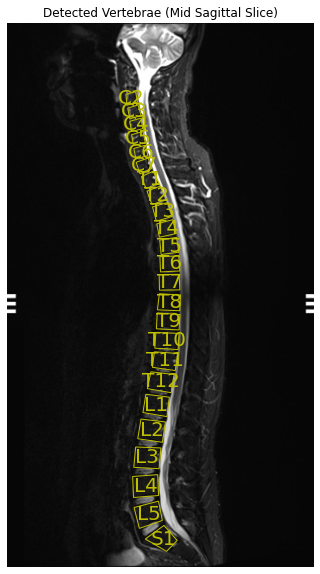

In [4]:

# detect and identify vertebrae in scan. Note that pixel spacing information is required 
# so SpineNet knows what size to split patches into.
vert_dicts = spnt.detect_vb(scan.volume, scan.pixel_spacing)

# now show results
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
# plot mid sagittal slice and detected vertebrae
plt.figure(figsize=(10,10))
plt.imshow(scan.volume[:,:,scan.volume.shape[-1]//2], cmap='gray')
for idx, vert_dict in enumerate(vert_dicts):
    # if scan.volume.shape[-1]//2 in vert_dict['slice_nos']:
    poly = np.array(vert_dict['average_polygon'])
    plt.gca().add_patch(Polygon(poly, fc='none', ec='y'))
    plt.text(np.mean(poly[:,0]), np.mean(poly[:,1]), vert_dict['predicted_label'], color='y',fontsize=20, va='center', ha='center')

plt.axis('off')
plt.title('Detected Vertebrae (Mid Sagittal Slice)')
plt.show()

## Save Vertebra Detection Results

Finally, save the results as a json file

In [5]:
results_folder = './results'
os.makedirs(results_folder, exist_ok=True)

from spinenet.io import save_vert_dicts_to_csv

save_vert_dicts_to_csv(vert_dicts, f'{results_folder}/{scan_name}_vert_dicts.csv')
